In [12]:
l = 1
m = 1
n = 1
p = 1
Amax = 100
Vmax = 100

In [13]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


def get_limit(lim, p):
    if p < lim[0] - 0.5:
        lim[0] = p - 0.5
    if p > lim[1] + 0.5:
        lim[1] = p + 0.5

    return lim


def update_limits(xlim, ylim, zlim, p):
    return get_limit(xlim, p[0]), get_limit(ylim, p[1]), get_limit(zlim, p[2])


def generate_lines(a, b, echant):
    x = np.linspace(a[0], b[0], echant)
    y = np.linspace(a[1], b[1], echant)
    z = np.linspace(a[2], b[2], echant)
    return x, y, z


def afficher(q, Xp = None):
    xlim = [-0.5, 0.5]
    ylim = [-0.5, 0.5]
    zlim = [0, 1.5]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    colors = ('black', 'yellow', 'blue', 'green')

    liaison_j = [0, 0, 0]

    for i in range(len(q)):
        liaison_i = liaison_j
        liaison_j = np.squeeze(np.asarray(getTij(0, i+1, q)[:3, 3:]))
        xline, yline, zline = generate_lines(liaison_i, liaison_j, 100)
        ax.plot3D(xline, yline, zline, colors[i])
        xlim, ylim, zlim = update_limits(xlim, ylim, zlim, liaison_j)

    liaison_i = liaison_j
    OT = np.squeeze(np.asarray(mgd(q)[:3]))
    xline, yline, zline = generate_lines(liaison_i, OT, 100)
    ax.plot3D(xline, yline, zline, colors[i+1])
    xlim, ylim, zlim = update_limits(xlim, ylim, zlim, OT)

    if Xp is not None:
        ax.scatter(Xp[0], Xp[1], Xp[2], marker='o')

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 2)

In [14]:
import numpy as np
from numpy import cbrt
from math import cos, sin, sqrt, pi, atan2, acos, atan

def invHomogene(matrice):
    R = np.asmatrix(matrice[:3, :3])
    P = np.asmatrix(matrice[:3, 3:])

    R2 = R.getT()
    P2 = - R2 * P
    res = np.concatenate((R2, P2), axis=1)
    res = np.concatenate((res, [[0, 0, 0, 1]]), axis=0)
    return res

def getTij(i, j, q):
    if i == j:
        return np.matrix(np.eye(4))
    if j == i+1:
        if i == 0:
            return getT01(q)
        if i == 1:
            return getT12(q)
        if i == 2:
            return getT23(q)
    if j > i:
        res = getTij(i, i + 1, q)
        for k in range(i + 1, j):
            res = res * getTij(k, k + 1, q)
        return res
    return invHomogene(getTij(j, i, q))

def getT01(q):
    q1 = q[0]
    return np.matrix([
                    [cos(q1), -sin(q1), 0, 0],
                    [sin(q1), cos(q1), 0, 0],
                    [0, 0, 1, l],
                    [0, 0, 0, 1]])

def getT12(q):
    q2 = q[1]
    return np.matrix([
                    [cos(q2), -sin(q2), 0, p],
                    [0, 0, -1, 0],
                    [sin(q2), cos(q2), 0, 0],
                    [0, 0, 0, 1]])

def getT23(q):
    q3 = q[2]
    return np.matrix([
        [cos(q3), -sin(q3), 0, m],
        [sin(q3), cos(q3), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

def mgd(q):
    T03 = getTij(0, 3, q)
    R = np.asmatrix(T03[:3, :3])
    P = np.asmatrix(T03[:3, 3:])

    Xp =  P + R * np.asmatrix([[n,0,0]]).getT()
    Xr = np.concatenate((R[:, 0], R[:, 2]), axis=0)

    return np.concatenate((Xp, Xr), axis=0)


In [15]:
q1fig = pi / 2
q2fig = 0
q3fig = pi/2
qfig = [q1fig, q2fig, q3fig]
X = mgd(qfig)

print(X)

[[ 1.22464680e-16]
 [ 2.00000000e+00]
 [ 2.00000000e+00]
 [ 3.74939946e-33]
 [ 6.12323400e-17]
 [ 1.00000000e+00]
 [ 1.00000000e+00]
 [-6.12323400e-17]
 [ 0.00000000e+00]]


In [16]:
def mgi(Xp, qinit):

    t14, t24, t34 = Xp


    q = []
    for e1 in [-1, 1]:
        if t24 == t14 == 0:
            q1 = qinit[0]
            print("Singularité")
        else:
            sq1 = sqrt(t24**2 + t14**2)
            s1 = e1 * t24 / sq1
            c1 = e1 * t14 / sq1
            q1 = atan2(s1, c1)

        s2 = (t34 - l) / m
        c2 = (cos(q1) * t14 + sin(q1) * t24 - p) / m
        q2 = atan2(s2, c2)

        T03 = getTij(0, 3, [q1, q2, 0])
        P03 = T03[:3, 3:]
        Xrx = Xp - P03
        t11, t21, t31 = Xrx / np.linalg.norm(Xrx)


        s23 = t31
        c23 = cos(q1) * t11 + sin(q1) * t21
        q23 = atan2(s23, c23)
        q3 = q23 - q2

        q.append([q1, q2, q3])

    res = next(q[i] for i in range(len(q)) if abs(qinit[0] - q[i][0]) == min([abs(qinit[0] - q[j][0]) for j in range(len(q))]))

    return res

def mgi_new(Xp, qinit):
    x0, y0, z0 = Xp
    if z0 < 0: return None

    q = []

    if x0 == y0 == 0:
        q1 = qinit[0]
        print("Singularité")
    else:
        sq1 = sqrt(y0**2 + x0**2)
        s1 = y0 / sq1
        c1 = x0 / sq1
        q1 = atan2(s1, c1)

    z1 = z0 - l
    x1 = sqrt(y0**2 + x0**2) - p

    c3 = ((x1**2 + z1**2) - (n**2 + m**2)) / (2 * m * n)

    q3s = []
    if c3 > 1:
        return None
    elif c3 == 1:
        q3s.append(0)
    else:
         for e3 in [-1, 1]:
             q3s.append(e3 * acos(c3))
    for q3 in q3s:
        s3 = sin(q3)
        s = sqrt(x1**2 + z1**2)
        steta = z1/s
        cteta = x1/s

        spteta = n * s3 / s
        cpteta = (m + n * c3) / s

        teta = atan2(steta, cteta)
        pteta = atan2(spteta, cpteta)
        # q2 = atan(z1/x1) - atan((n * s3) / (m + n * c3))
        # Avec les atan2 c'est mieux
        q2 = teta - pteta

        q.append([q1, q2, q3])

    res = next(q[i] for i in range(len(q)) if abs(qinit[2] - q[i][2]) == min([abs(qinit[2] - q[j][2]) for j in range(len(q))]))
    return res

Singularité
Xp [[0.]
 [0.]
 [2.]]
Q [0, 1.5707963267948966, 1.5707963267948966]


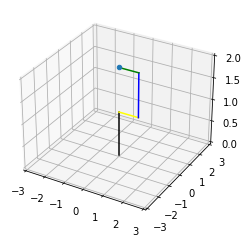

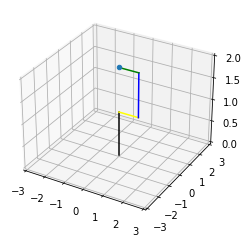

In [17]:
"""
q1fig = pi/4
q2fig = pi/2 +1
q3fig = pi/2
qfig = [q1fig, q2fig, q3fig]
X = mgd(qfig)
Xp = X[:3]
Q = mgi_new(Xp, qfig)

print(Xp)
afficher(qfig, Xp)
afficher(Q, Xp)
"""

q1fig = 0
q2fig = pi/2
q3fig = pi/2
qfig = [q1fig, q2fig, q3fig]
X = mgd(qfig)
Xp = X[:3]
Q = mgi_new(Xp, qfig)

print("Xp", Xp)
print("Q", Q)
afficher(qfig, Xp)
afficher(Q, Xp)


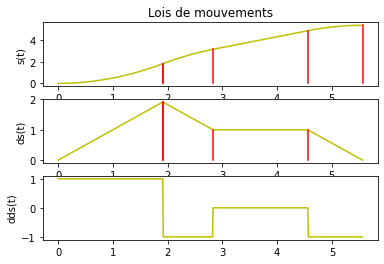

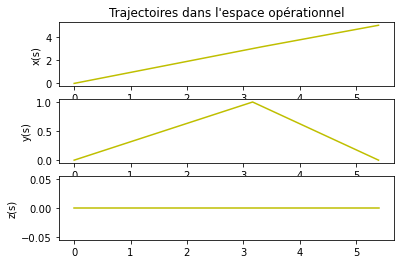

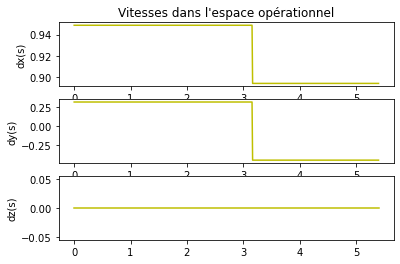

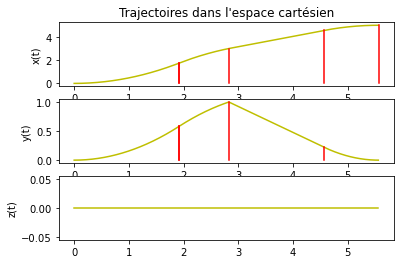

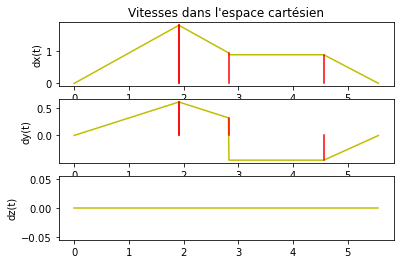

In [22]:
def getNewParams1(V2, AB, Amax):
    """
    racine_cube = cbrt(sqrt(4 * (6 * Amax - Amax**2)**3 + (-2 * Amax**3 + 54 * Amax**2 * AB + 18 * Amax**2 + 54 * Amax * V2)**2) + 54 * Amax * V2 - 2 * Amax**3 + 54 * Amax**2 * AB + 18 * Amax**2)

    v = racine_cube / (3 * cbrt(2)) - cbrt(2) * (6 * Amax - Amax**2) / (3 * racine_cube) - Amax / 3
    t12 = (2 * Amax * AB + 2 * V2 - 2 * v) / (Amax * v) + v**2
    t3 = (v * V2) / Amax + t12
    """

    v = sqrt((V2**2 + 2 * AB * Amax) / 2)
    #print(v)
    t12 = ((V2 - v) / Amax * V2 * 2 + (v - V2) * (V2 - v) / Amax + 2 * AB) / v
    t3 = (v - V2) / Amax + t12

    return t12, t3

def getParams(V1, V2, Amax, A, B, C):
    if V1 > Vmax or V2 > Vmax: return None
    t = [0 for _ in range(6)]
    t[0] = 0
    t[1] = V1/Amax
    AB = np.linalg.norm(np.array(B) - np.array(A))
    t[3] = (AB - (V1 * t[1] ) / 2 - ((V1 + V2) * (V1 - V2)) / (Amax * 2) + V1 * t[1] + V1 * (V1 - V2) / Amax) / V1
    t[2] = t[3] - (V1 - V2) / Amax
    if (Amax * (V2/Amax)**2) / 2 > AB:
        t[1] = t[2] = t[3] = V2/Amax
        BC = np.linalg.norm(np.array(C)) - (Amax * (V2/Amax)**2) / 2
    elif t[1] > t[2]:
    #if (Amax * (V1/Amax)**2) / 2 > AB:
        t12, t3 = getNewParams1(V2, AB, Amax)
        t[1] = t12
        t[2] = t12
        t[3] = t3
        BC = np.linalg.norm(np.array(C) - np.array(B))
    t[5] = BC / V2 + t[3] + V2 / Amax - V2 / (2 * Amax)
    t[4] = t[5] - V2 / Amax
    #print(t)
    return t


def s_gen(t, V1, V2, Amax, A, B, C):
    ts = getParams(V1, V2, Amax, A, B, C)
    t0 = ts[0]
    t1 = ts[1]
    t2 = ts[2]
    t3 = ts[3]
    t4 = ts[4]
    tf = ts[5]

    if t <= t1:
        return (Amax * t**2) / 2
    if t <= t2:
        return s_gen(t1, V1, V2, Amax, A, B, C) + Amax * t1 * (t - t1)
    if t <= t3:
        return s_gen(t2, V1, V2, Amax, A, B, C) - (Amax * (t - t2)**2) / 2 + Amax * t1 * (t - t2)
    if t <= t4:
        return s_gen(t3, V1, V2, Amax, A, B, C) + V2 * (t - t3)
    if t <= tf:
        return s_gen(t4, V1, V2, Amax, A, B, C) - (Amax * (t - t4)**2) / 2 + V2 * (t - t4)


def ds_gen(t, V1, V2, Amax, A, B, C):
    ts = getParams(V1, V2, Amax, A, B, C)
    t0 = ts[0]
    t1 = ts[1]
    t2 = ts[2]
    t3 = ts[3]
    t4 = ts[4]
    tf = ts[5]

    if t <= t1:
        return Amax * t
    if t <= t2:
        return Amax * t1
    if t <= t3:
        return -Amax * (t - t2) + Amax * t1
    if t <= t4:
        return V2
    if t <= tf:
        return -Amax * (t - t4) + V2
    return 0


def dds_gen(t, V1, V2, Amax, A, B, C):
    ts = getParams(V1, V2, Amax, A, B, C)
    t0 = ts[0]
    t1 = ts[1]
    t2 = ts[2]
    t3 = ts[3]
    t4 = ts[4]
    tf = ts[5]

    if t <= t1:
        return Amax
    if t <= t2:
        return 0
    if t <= t3:
        return -Amax
    if t <= t4:
        return 0
    if t <= tf:
        return -Amax
    return 0

def affiche_lois_mouvements(s, ds, dds, ts):

    xs = []
    ys = []
    xds = []
    yds = []
    xdds = []
    ydds = []
    for t in np.arange(0, ts[5], step=0.01):
        xs.append(t)
        ys.append(s(t))

        xds.append(t)
        yds.append(ds(t))

        xdds.append(t)
        ydds.append(dds(t))
        if t != 0 and ds(t) == 0: break
        if s(t) is None: break

    plt.figure()
    plt.subplot(311)
    plt.title("Lois de mouvements")
    plt.ylabel("s(t)")
    plt.plot(xs, ys, "y-")
    for t in ts:
        plt.plot([t, t], [0, s(t)], "r-")

    plt.subplot(312)
    plt.ylabel("ds(t)")
    plt.plot(xds, yds, "y-")
    for t in ts:
        plt.plot([t, t], [0, ds(t)], "r-")


    plt.subplot(313)
    plt.ylabel("dds(t)")
    plt.plot(xdds, ydds, "y-")
    plt.show()


def affiche_position_s(x, y, z, s):

    xs = []
    ys = []
    xds = []
    yds = []
    xdds = []
    ydds = []
    for t in np.arange(0, 100, step=0.01):
        xs.append(s(t))
        ys.append(x(t))

        xds.append(s(t))
        yds.append(y(t))

        xdds.append(s(t))
        ydds.append(z(t))
        if s(t) is None: break

    plt.figure()
    plt.subplot(311)
    plt.title("Trajectoires dans l'espace opérationnel")
    plt.ylabel("x(s)")
    plt.plot(xs, ys, "y-")

    plt.subplot(312)
    plt.ylabel("y(s)")
    plt.plot(xds, yds, "y-")

    plt.subplot(313)
    plt.ylabel("z(s)")
    plt.plot(xdds, ydds, "y-")
    plt.show()


def affiche_vitesse_s(dx, dy, dz, s):

    xs = []
    ys = []
    xds = []
    yds = []
    xdds = []
    ydds = []
    for t in np.arange(0, 100, step=0.01):
        xs.append(s(t))
        ys.append(dx(t))

        xds.append(s(t))
        yds.append(dy(t))

        xdds.append(s(t))
        ydds.append(dz(t))
        if s(t) is None: break

    plt.figure()
    plt.subplot(311)
    plt.title("Vitesses dans l'espace opérationnel")
    plt.ylabel("dx(s)")
    plt.plot(xs, ys, "y-")

    plt.subplot(312)
    plt.ylabel("dy(s)")
    plt.plot(xds, yds, "y-")

    plt.subplot(313)
    plt.ylabel("dz(s)")
    plt.plot(xdds, ydds, "y-")
    plt.show()


def affiche_position(x, y, z, s, ts):

    xs = []
    ys = []
    xds = []
    yds = []
    xdds = []
    ydds = []
    for t in np.arange(0, ts[5], step=0.01):
        xs.append(t)
        ys.append(x(t))

        xds.append(t)
        yds.append(y(t))

        xdds.append(t)
        ydds.append(z(t))
        if s(t) is None: break

    plt.figure()
    plt.subplot(311)
    plt.title("Trajectoires dans l'espace cartésien")
    plt.ylabel("x(t)")
    plt.plot(xs, ys, "y-")
    for t in ts:
        plt.plot([t, t], [0, x(t)], "r-")

    plt.subplot(312)
    plt.ylabel("y(t)")
    plt.plot(xds, yds, "y-")
    for t in ts:
        plt.plot([t, t], [0, y(t)], "r-")

    plt.subplot(313)
    plt.ylabel("z(t)")
    plt.plot(xdds, ydds, "y-")
    for t in ts:
        plt.plot([t, t], [0, z(t)], "r-")
    plt.show()


def affiche_vitesse(dx, dy, dz, s, ts):

    xs = []
    ys = []
    xds = []
    yds = []
    xdds = []
    ydds = []
    for t in np.arange(0, ts[5], step=0.01):
        xs.append(t)
        ys.append(dx(t))

        xds.append(t)
        yds.append(dy(t))

        xdds.append(t)
        ydds.append(dz(t))
        if s(t) is None: break

    plt.figure()
    plt.subplot(311)
    plt.title("Vitesses dans l'espace cartésien")
    plt.ylabel("dx(t)")
    plt.plot(xs, ys, "y-")
    for t in ts:
        plt.plot([t, t], [0, dx(t)], "r-")

    plt.subplot(312)
    plt.ylabel("dy(t)")
    plt.plot(xds, yds, "y-")
    for t in ts:
        plt.plot([t, t], [0, dy(t)], "r-")

    plt.subplot(313)
    plt.ylabel("dz(t)")
    plt.plot(xdds, ydds, "y-")
    for t in ts:
        plt.plot([t, t], [0, dz(t)], "r-")
    plt.show()



def trajectoire(A, B, C, V1, V2, Amax):
    def s(t):
        return s_gen(t, V1, V2, Amax, A, B, C)
    def ds(t):
        return ds_gen(t, V1, V2, Amax, A, B, C)
    def dds(t):
        return dds_gen(t, V1, V2, Amax, A, B, C)
    ts = getParams(V1, V2, Amax, A, B, C)

    AB = np.array(B) - np.array(A)
    BC = np.array(C) - np.array(B)

    DAB = np.linalg.norm(AB)
    DBC = np.linalg.norm(BC)
    u = AB / DAB
    u2 = BC / DBC

    def xs(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[0] * ss + A[0]
        else:
            return u2[0] * (ss - DAB) + B[0]
    def ys(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[1] * ss + A[1]
        else:
            return u2[1] * (ss - DAB) + B[1]
    def zs(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[2] * ss + A[2]
        else:
            return u2[2] * (ss - DAB) + B[2]


    def dxs(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[0]
        else:
            return u2[0]
    def dys(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[1]
        else:
            return u2[1]
    def dzs(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[2]
        else:
            return u2[2]

    def dx(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[0] * ds(t)
        else:
            return u2[0] * ds(t)
    def dy(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[1] * ds(t)
        else:
            return u2[1] * ds(t)
    def dz(t):
        ss = s(t)
        if ss is None: return None
        if ss <= DAB:
            return u[2] * ds(t)
        else:
            return u2[2] * ds(t)


    affiche_lois_mouvements(s, ds, dds, ts)
    affiche_position_s(xs, ys, zs, s)
    affiche_vitesse_s(dxs, dys, dzs, s)
    affiche_position(xs, ys, zs, s, ts)
    affiche_vitesse(dx, dy, dz, s, ts)


xs = []
ys = []

xds = []
yds = []

xdds = []
ydds = []

A = [0, 0, 0]
B = [3, 1, 0]
C = [5, 0, 0]
V1 = 99
V2 = 1
Amax = 1


trajectoire(A, B, C, V1, V2, Amax)

In [19]:
def getJacobienne(q):
    q1 = q[0]
    q2 = q[1]
    q3 = q[2]

    f1q1 = -n * sin(q1) * (cos(q3) * cos(q2) - sin(q2) * sin(q3)) - sin(q1) * (m * cos(q2) + p) - cos(q1) * m * sin(q2)
    f1q2 = -cos(q1) * n * (cos(q3) * sin(q2) + cos(q2) * sin(q3))
    f1q3 = -cos(q1) * n * (cos(q3) * sin(q2) + cos(q2) * sin(q3))

    f2q1 = n * cos(q1) * (cos(q3) * sin(q2) - sin(q3) * sin(q2)) + cos(q1) * (p + m * cos(q2))
    f2q2 = -sin(q1) * n * (cos(q3) * sin(q2) + cos(q2) * sin(q3)) - sin(q1) * m * sin(q2)
    f2q3 = -sin(q1) * n * (cos(q3) * sin(q2) + cos(q2) * sin(q3))

    f3q1 = 0
    f3q2 = n * (cos(q3) * cos(q2) - sin(q3) * sin(q2))
    f3q3 = n * (cos(q3) * cos(q2) - sin(q3) * sin(q2))

    return np.matrix([
        [f1q1, f1q2, f1q3],
        [f2q1, f2q2, f2q3],
        [f3q1, f3q2, f3q3]])

print(getJacobienne(Q))
print(np.linalg.inv(getJacobienne(Q)))


[[-1.00000000e+00 -1.22464680e-16 -1.22464680e-16]
 [ 1.11022302e-16 -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00 -1.00000000e+00]]


LinAlgError: Singular matrix